In [1]:
#encoding="utf-8"
import pandas as pd
import numpy as np
import time
import requests
import json

c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [151]:
# 获取火币或者T8或者币安历史合约K线收盘价数据
def get_future_klinedata0(platform, symbol, granularity=400):
    if platform == 'huobi':
        for _ in range(3):
            now = int(time.time())
            start_time = now - 86400 * granularity
            contract_code = "{}-usdt".format(symbol).upper()
            url = huobifuture_api_url + '/linear-swap-ex/market/history/kline?contract_code={}&period=1day&from={}&to={}'.format(
                contract_code, start_time, now)
            try:
                res = requests.get(url)
                if res.status_code ==200:
                    resdict = json.loads(res.content.decode())
                    df = pd.DataFrame()
                    df['close'] = [i['close'] for i in resdict['data']]
                    break
            except Exception as e:
                print(e)
                df = pd.DataFrame()
        return df
    elif platform == "T8ex":
        try:
            contract_id_dict = {'BTC': 1, 'ETH': 2, 'LINK': 3, 'EOS': 4, 'FIL': 5, 'LTC': 6, 'UNI': 7, 'DOT': 8,
                                'DOGE': 9}
            contract_id = contract_id_dict[symbol.upper()]
            now = int(time.time())
            start_time = now - 86400 * granularity
            url = T8ex_kline_url + "?contractId={}&from={}&to={}&resolution={}".format(contract_id, start_time * 1000,
                                                                                       now * 1000, "1D")
            res = requests.get(url).json()
            df = pd.DataFrame()
            df['close'] = [i[4] for i in res]
        except Exception as e:
            print(e)
            df = pd.DataFrame()
        finally:
            return df

    elif platform == "binance":
        for _ in range(3):
            url = binancefuture_api_url + '/dapi/v1/continuousKlines'
            pair = "{}usd".format(symbol).upper()
            now = int(time.time())
            start_time = now - 86400 * granularity
            data = {'pair': pair, 'contractType': "PERPETUAL", 'interval': '1d', 'starttime': start_time * 1000,
                    'endtime': now * 1000}
            try:
                response = requests.get(url, params=data, timeout=1)
                if response.status_code == 200:
                    res = response.json()
                    df = pd.DataFrame()
                    df['close'] = [float(i[4]) for i in res]
                    break
            except Exception as e:
                print(e)
        return df


In [152]:
#获取多个币种永续合约的30日收盘价
def get_contracts_klinedata(platform, symbols):
    contracts_klinedata = None
    for symbol in symbols:
        df = get_future_klinedata0(platform, symbol)
        df.rename(columns={'close': symbol}, inplace=True)
        contracts_klinedata = df if contracts_klinedata is None else pd.concat([contracts_klinedata, df], axis=1)
    return contracts_klinedata

#获取永续合约持仓
def future_position(platform,symbol):
    if platform=="binance":
        url='https://dapi.binance.com/futures/data/openInterestHist'
        #now = int(time.time())-86400 *29
        data={'symbol':symbol,'period':'1d',"pair":"{}USD".format(symbol)}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                response=requests.get(url,params=data)
                if response.status_code==200:
                    res=response.json()
                    df[symbol]=[float(i['sumOpenInterest']) for i in res]
                    #df['time']=[time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i["timestamp"]/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
        return df 
    elif platform=="huobi":
        url='https://api.btcgateway.pro/linear-swap-api/v1/swap_his_open_interest'
        data={'contract_code':'{}-usdt'.format(symbol).upper(),'period':'1day',"amount_type":1}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                response=requests.get(url,params=data)
                if response.status_code==200:
                    res=response.json()['data']['tick']
                    df[symbol]=[float(i['value']) for i in res]
                    break
            except Exception as e:
                print(e)
        return df


In [153]:
#复合动量因子
def compound_momentum(symbols,df):
    judge_list=None
    for symbol in symbols:
        df['return']=df[symbol].pct_change().dropna()
        up_days=np.sum(df['return'].values>0)
        down_days=np.sum(df['return'].values>0)
        return_all=df['return'].sum()
        judge=pd.DataFrame({symbol:[up_days/(up_days+down_days)*return_all]})
        #judge=pd.DataFrame({symbol:[1*return_all]})
        judge_list =judge.T if judge_list is None else pd.concat([judge_list,judge.T],axis=0)
    judge_list.columns=['return']
    judge_list.sort_values(by=['return'], ascending=True, inplace=True)
    return judge_list

In [154]:
#收益率偏度因子
def skew_factor(symbols,df):
    skew_list=None
    for symbol in symbols:
        #df=get_future_klinedata0("T8ex",symbol)
        ret=np.log(df[symbol]/df[symbol].shift())
        ret.columns=[symbol]
        ret_skew=pd.DataFrame({symbol:[ret.skew()]}) #计算偏度后转置，index为【future】,即期货种类代码
        skew_list=ret_skew.T if skew_list is None else pd.concat([skew_list,ret_skew.T],axis=0)
    skew_list.columns=['skew']
    skew_list.sort_values(by=['skew'],ascending=False,inplace=True)
    return skew_list

In [155]:
#仓单因子
def ware_house_factor(symbols,df):
    ware_house_list=None
    for symbol in symbols:
        ware_house_pct=pd.DataFrame({symbol:[(float(df[symbol].iloc[-1])-float(df[symbol].iloc[0]))/float(df[symbol].iloc[0])]})
        ware_house_list =ware_house_pct.T if ware_house_list is None else pd.concat([ware_house_list,ware_house_pct.T],axis=0)
    ware_house_list.columns=['position_change']
    ware_house_list.sort_values(by=['position_change'],ascending=False,inplace=True)
    ware_house_list.dropna(inplace=True)
    return ware_house_list

In [156]:
def weighted_factor_score(factor, factor_name, weight):
    #给定每只期货合约的因子数据及权重，返回加权后的打分结果
    # weight是因子的权重，是该因子多空组合夏普比率，计算过程省了
    factor.columns = [factor_name]
    factor.iloc[:2]=1
    factor.iloc[2:-2]=0
    factor.iloc[-2:]=-1
    factor = factor*weight 
    return factor

In [157]:
#获得多个币种近30日的持仓详情
def get_all_position(symbols):
    all_position=None
    for symbol in symbols:
        df=future_position("huobi",symbol)
        all_position=df if all_position is None else pd.concat([all_position,df],axis=1)
    return all_position

In [229]:
T8ex_kline_url="http://47.241.181.195:1060/contract-market/history"
huobifuture_api_url='https://api.btcgateway.pro'
symbols = ['btc','eth','link','eos','fil','ltc','dot','doge','uni']
#symbols=['btc','eth','link','eos','fil','ltc','dot','uni']
df=get_contracts_klinedata("huobi",symbols)
#df_index= get_symbols_klinedata("huobi",symbols,86400)

In [230]:
df['doge']=df['doge'].shift(336-252)
df['eos']=df['eos'].shift(336-315)
df['ltc']=df['ltc'].shift(336-315)

In [231]:
df

,btc,eth,link,eos,fil,ltc,dot,doge,uni
0,12701.9,390.32,10.8299,NaN,28.786,NaN,4.0872,NaN,2.9988
1,12953.0,413.20,11.6952,NaN,25.708,NaN,4.2868,NaN,3.0790
2,12881.9,413.03,11.9304,NaN,22.330,NaN,4.3075,NaN,3.0202
3,13102.2,412.43,12.6396,NaN,24.131,NaN,4.3572,NaN,2.9969
4,12883.3,405.62,12.0931,NaN,33.315,NaN,4.2929,NaN,2.8890
5,12978.0,394.22,11.6075,NaN,34.917,NaN,4.5660,NaN,2.6551
6,13598.5,406.13,12.1705,NaN,34.127,NaN,4.7415,NaN,2.7945
7,13221.2,387.58,11.5186,NaN,34.433,NaN,4.3656,NaN,2.6582
8,13420.6,390.17,11.5914,NaN,32.617,NaN,4.1373,NaN,2.6140
9,13531.9,381.67,11.0941,NaN,30.231,NaN,4.0899,NaN,2.3510


In [124]:
positions=get_all_position(symbols)

In [142]:
positions

,btc,eth,link,eos,fil,ltc,dot,doge,uni
0,2.649326e+08,1.940263e+08,7.617881e+06,1.518869e+07,3.148231e+07,1.492577e+07,1.875474e+07,2.519119e+07,5.171740e+06
1,2.493770e+08,1.884148e+08,8.093493e+06,1.689211e+07,3.238667e+07,1.600800e+07,2.055189e+07,2.612413e+07,5.166848e+06
2,2.490438e+08,1.750251e+08,7.896225e+06,1.539622e+07,2.937868e+07,1.617605e+07,1.933613e+07,2.912016e+07,4.838138e+06
3,2.706337e+08,1.697627e+08,6.824952e+06,1.465844e+07,2.733800e+07,1.625504e+07,1.903012e+07,2.862194e+07,5.209498e+06
4,2.359858e+08,1.775648e+08,7.243666e+06,1.717072e+07,3.015114e+07,1.574772e+07,2.109808e+07,2.885406e+07,5.217358e+06
5,2.524621e+08,1.737899e+08,6.887335e+06,1.381614e+07,3.040805e+07,1.609469e+07,2.171542e+07,2.586932e+07,5.547150e+06
6,2.573834e+08,1.733248e+08,7.698365e+06,1.222165e+07,2.819855e+07,1.825760e+07,2.060212e+07,2.503665e+07,5.226301e+06
7,2.304837e+08,1.768010e+08,7.907999e+06,1.128191e+07,2.839004e+07,2.011964e+07,2.029390e+07,2.515150e+07,7.028858e+06
8,2.173580e+08,1.831715e+08,8.089571e+06,1.137181e+07,2.788451e+07,3.268489e+07,2.075113e+07,2.554182e+07,5.695152e+06
9,2.154073e+08,1.798040e+08,7.191595e+06,1.130386e+07,2.837788e+07,1.326309e+07,2.117775e+07,2.878142e+07,6.632333e+06


In [252]:
result_list=None
for i in range(337-50):
    #factor_momentum = weighted_factor_score(basic_momentum(symbols,df.iloc[i+1:50+i+1],df_index.iloc[i+1:50+i+1]), '基差动量',1)    #调仓频繁
    judge_list = weighted_factor_score(compound_momentum(symbols,df.iloc[i+1:50+i+1]), '复合动量',0) #周调仓
    skew_list = weighted_factor_score(skew_factor(symbols,df.iloc[i+1:50+i+1]), '偏度',1)  #周调仓
    #ware_house = weighted_factor_score(ware_house_factor(symbols,positions.iloc[i+1:i+10+1]), '仓单因子', 1)
    #factor_pure_long = weighted_factor_score(pure_long_factor(symbols,pure_long_position.iloc[i+1:i+20+1]), '净多头变化率', 1)
    result = pd.concat([judge_list,skew_list], axis=1)
    result = result.sum(axis=1).sort_values(ascending=False)
    result.iloc[:2] = 1
    result.iloc[2:-2] = 0
    result.iloc[-2:] = -1
    result_list = result if result_list is None else pd.concat([result_list,result], axis=1)

<ipython-input-153-64f33d1ef32d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return']=df[symbol].pct_change().dropna()
<ipython-input-153-64f33d1ef32d>:9: RuntimeWarning: invalid value encountered in long_scalars
  judge=pd.DataFrame({symbol:[up_days/(up_days+down_days)*return_all]})


In [253]:
pd.set_option('display.max_rows', None)
result_list.T

,fil,uni,btc,eth,ltc,dot,link,doge,eos
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0


In [254]:
result=result_list.T.reset_index(drop=True)

In [255]:
len(result)

287

In [256]:
result=result_list.T.reset_index(drop=True)
df['btc_pct']=np.log(df['btc']/df['btc'].shift())
df['eth_pct']=np.log(df['eth']/df['eth'].shift())
df['link_pct']=np.log(df['link']/df['link'].shift())
df['eos_pct']=np.log(df['eos']/df['eos'].shift())
df['fil_pct']=np.log(df['fil']/df['fil'].shift())
df['ltc_pct']=np.log(df['ltc']/df['ltc'].shift())
df['uni_pct']=np.log(df['uni']/df['uni'].shift())
df['dot_pct']=np.log(df['dot']/df['dot'].shift())
df['doge_pct']=np.log(df['doge']/df['doge'].shift())
# df['btc_pct']=df['btc'].pct_change()
# df['eth_pct']=df['eth'].pct_change()
# df['link_pct']=df['link'].pct_change()
# df['eos_pct']=df['eos'].pct_change()
# df['fil_pct']=df['fil'].pct_change()
# df['ltc_pct']=df['ltc'].pct_change()
# #df['uni_pct']=df['uni'].pct_change()
# df['dot_pct']=df['dot'].pct_change()
# df['doge_pct']=df['doge'].pct_change()
df_2=df[['btc_pct','eth_pct','link_pct','eos_pct','fil_pct','ltc_pct','dot_pct','doge_pct']]
df_3=df_2.iloc[50:].reset_index(drop=True)

In [257]:
len(df_3)

287

In [261]:
df_1=pd.concat([df_3,result],axis=1)
df_1['btc_return']=df_1['btc_pct']*df_1['btc'].shift()
df_1['eth_return']=df_1['eth_pct']*df_1['eth'].shift()
df_1['link_return']=df_1['link_pct']*df_1['link'].shift()
df_1['eos_return']=df_1['eos_pct']*df_1['eos'].shift()
df_1['fil_return']=df_1['fil_pct']*df_1['fil'].shift()
df_1['ltc_return']=df_1['ltc_pct']*df_1['ltc'].shift()
#df_1['uni_return']=df_1['uni_pct']*df_1['uni'].shift()
df_1['dot_return']=df_1['dot_pct']*df_1['dot'].shift()
df_1['doge_return']=df_1['doge_pct']*df_1['doge'].shift()
df_4=df_1[['btc_return','eth_return','link_return','eos_return','fil_return','ltc_return','dot_return','doge_return']]
df_4['return']=df_4.sum(axis=1)

<ipython-input-261-11bee12c615e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['return']=df_4.sum(axis=1)


In [259]:
#df_4.fillna(0,inplace=True)

c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\pandas\core\frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<AxesSubplot:>

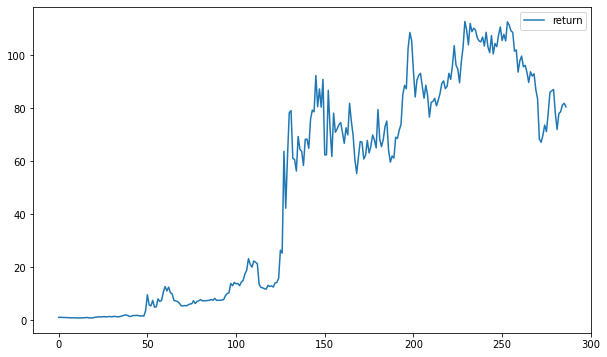

In [262]:
df_4[['return']].cumsum().apply(np.exp).plot(figsize=(10,6))